In [7]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh
# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [5]:
class RelEmbed(object):
    """ Encapsulation of the dependency RNN lang model"""
    def __init__(self, config):
        self.max_num_steps = config['max_num_steps']
        self.word_embed_size = config['word_embed_size']
        self.dep_embed_size = config['dep_embed_size']
        self.input_size = self.word_embed_size + self.dep_embed_size
        self.hidden_size = 2 * self.word_embed_size #config['hidden_size']
        self.pretrained_word_embeddings = config['pretrained_word_embeddings'] # None if we don't provide them
        if np.any(self.pretrained_word_embeddings):
            assert self.word_embed_size == self.pretrained_word_embeddings.shape[1]
        self.num_classes = config['num_predict_classes']
        self.max_grad_norm = config['max_grad_norm']
        
        self.vocab_size = config['vocab_size']
        self.dep_vocab_size = config['dep_vocab_size']
        self.name = config['model_name']
        self.checkpoint_prefix = config['checkpoint_prefix'] + self.name
        self.summary_prefix = config['summary_prefix'] + self.name
        
        self.initializer = tf.random_uniform_initializer(-1., 1.)
        with tf.name_scope(self.name):
            with tf.name_scope("Forward"):
                self._build_forward_graph()
                with tf.name_scope("Classification"):
                    self._build_classification_graph()
            with tf.name_scope("Backward"):
                self._build_train_graph()
                self._build_class_train_graph()
            with tf.name_scope("Nearby"):
                self._build_similarity_graph()
        
        self._valid_accuracy = tf.Variable(0.0, trainable=False)
        self._valid_acc_summary = tf.merge_summary([tf.scalar_summary("Valid_accuracy", self._valid_accuracy)])

        self.saver = tf.train.Saver(tf.all_variables(), max_to_keep=config['max_checkpoints'])
            
        self.session = tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())        
        self.summary_writer = tf.train.SummaryWriter(self.summary_prefix, self.session.graph_def)
        
    def save_validation_accuracy(self, new_score):
        assign_op = self._valid_accuracy.assign(new_score)
        _, summary = self.session.run([assign_op, self._valid_acc_summary])
        self.summary_writer.add_summary(summary)
        
    def _build_forward_graph(self):
        # input tensor of zero padded indices to get to max_num_steps
        # None allows for variable batch sizes
        self._lambda = tf.Variable(.001, trainable=False, name="L2_Lambda")
        with tf.name_scope("Inputs"):
            self._input_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 2]) # [batch_size, w_{1:N}, 2]
            self._input_targets = tf.placeholder(tf.int32, [None, 2]) # [batch_size, w_x]
            self._input_labels = tf.placeholder(tf.int32, [None, 1]) # [batch_size, from true data?] \in {0,1}
            self._input_lengths = tf.placeholder(tf.int32, [None, 1]) # [batch_size, N] (len of each sequence)
            self._keep_prob = tf.placeholder(tf.float32) # keep prob for drop out
            batch_size = tf.shape(self._input_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            if np.any(self.pretrained_word_embeddings):
                self._word_embeddings = tf.Variable(self.pretrained_word_embeddings,name="word_embeddings")
                self._left_target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="left_target_embeddings")
                self._right_target_embeddings = tf.Variable(self.pretrained_word_embeddings, name="right_target_embeddings")
            else:
                self._word_embeddings = tf.get_variable("word_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
                self._left_target_embeddings = tf.get_variable("left_target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
                self._right_target_embeddings = tf.get_variable("right_target_embeddings", 
                                                        [self.vocab_size, self.word_embed_size],
                                                        dtype=tf.float32)
            
            self._dependency_embeddings = tf.get_variable("dependency_embeddings", 
                                                    [self.dep_vocab_size, self.dep_embed_size],
                                                    dtype=tf.float32)
            # TODO: Add POS embeddings
            
            input_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._input_phrases, [0,0,0], [-1, -1, 1])),
                                         self._keep_prob)
            dep_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1])),
                                       self._keep_prob)
            left_target_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._left_target_embeddings, 
                                                        tf.slice(self._input_targets, [0,0], [-1, 1])),
                                               self._keep_prob)
            right_target_embeds = tf.nn.dropout(tf.nn.embedding_lookup(self._right_target_embeddings, 
                                                        tf.slice(self._input_targets, [0,1], [-1, 1])),
                                                self._keep_prob)
#             print(tf.slice(self._input_phrases, [0,0,1], [-1, -1, 1]).get_shape(), dep_embeds.get_shape())
#             print(left_target_embeds.get_shape(), right_target_embeds.get_shape())
            self._target_embeds = tf.squeeze(tf.concat(2, [left_target_embeds, right_target_embeds]), [1])
#             print(target_embeds.get_shape())
            # TODO: Add dropout to embeddings
        
        with tf.name_scope("RNN"):
            # start off with a basic configuration
            self.cell = tf.nn.rnn_cell.GRUCell(self.hidden_size, 
                                                input_size=self.input_size)
            # TODO: Add Dropout wrapper
            # TODO: Make it multilevel
#             self._initial_state = self.cell.zero_state(batch_size, tf.float32)
#             print(self._initial_state.get_shape())
            input_words = [ tf.squeeze(input_, [1, 2]) for input_ in tf.split(1, self.max_num_steps, input_embeds)]
            input_deps = [ tf.squeeze(input_, [1, 2]) for input_ in tf.split(1, self.max_num_steps, dep_embeds)]
            inputs = [ tf.concat(1, [input_word, input_dep]) 
                      for (input_word, input_dep) in zip(input_words, input_deps)]

            _, state = tf.nn.rnn(self.cell, inputs, 
                                 sequence_length=tf.squeeze(self._input_lengths, [1]),
                                 dtype=tf.float32)
#                                  initial_state=self._initial_state)
            self._final_state = tf.nn.dropout(state, self._keep_prob)
            
        with tf.name_scope("Loss"):
            flat_states = tf.reshape(state, [-1])
            flat_target_embeds = tf.reshape(self._target_embeds, [-1])
#             assert self.hidden_size == (self.word_embed_size), "Hidden state must equal concated inputs" 
            flat_logits = tf.mul(flat_states, flat_target_embeds)
            logits = tf.reduce_sum(tf.reshape(flat_logits, tf.pack([batch_size, -1])), 1)
            self._logit_l2_penalty = self._lambda*tf.nn.l2_loss(logits, name='l2_penalty')
            self._xent = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, 
                                                                    tf.to_float(self._input_labels)),
                                        name="neg_sample_loss")
            self._loss = self._xent + self._logit_l2_penalty
            
        with tf.name_scope("Summaries"):
            logit_mag = tf.histogram_summary("Logit_magnitudes", logits)
            l2 = tf.scalar_summary("L2_penalty", self._logit_l2_penalty)
            xent = tf.scalar_summary("Sigmoid_xent", self._xent)
            self._penalty_summary = tf.merge_summary([logit_mag, l2, xent])
            self._train_cost_summary = tf.merge_summary([tf.scalar_summary("Train_NEG_Loss", self._loss)])
            self._valid_cost_summary = tf.merge_summary([tf.scalar_summary("Validation_NEG_Loss", self._loss)])
        
    def _build_classification_graph(self):
        with tf.name_scope("Classifier"):
            self._softmax_input = tf.concat(1, [self._final_state, self._target_embeds], name="concat_input")
            # instead of concat lets element wise multiply
            # TODO: Try out additive and cubic polynomial also
#         self._softmax_wh = tf.get_variable("softmax_w", [self.class_hidden_size, self._final_state.get_shape()[0]])
#             self._softmax_wl = tf.get_variable("softmax_w", [self.class_hidden_size, self._left_target_embeds.get_shape()[0]])
#             self._softmax_wr = tf.get_variable("softmax_w", [self.class_hidden_size, self._final_state.get_shape()[0]])
#             self._softmax_hb = tf.Variable(tf.zeros([self.num_classes], dtype=tf.float32), name="softmax_hb")
            
#             self._softmax_ws = tf.get_variable("softmax_ws", [self.class_hidden_size, self.num_classes])
#             self._softmax_sb = tf.Variable(tf.zeros([self.num_classes], dtype=tf.float32), name="softmax_sb")
#             self._softmax_input = tf.mul(self._final_state, self._target_embeds, name="mult_input") 
            self._softmax_w = tf.get_variable("softmax_w", [self._softmax_input.get_shape()[1], self.num_classes])
            self._softmax_b = tf.Variable(tf.zeros([self.num_classes], dtype=tf.float32), name="softmax_b")

            class_logits = tf.matmul(self._softmax_input, self._softmax_w) + self._softmax_b
            self._class_softmax_l2 = self._lambda*(tf.nn.l2_loss(self._softmax_w) + tf.nn.l2_loss(self._softmax_b))
            self._predictions = tf.argmax(class_logits, 1, name="predict")
            self._predict_probs = tf.nn.softmax(class_logits, name="predict_probabilities")
        
        with tf.name_scope("Loss"):
            self._class_labels = tf.placeholder(tf.int64, [None, 1])
            self._avg_class_xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(class_logits, 
                                                                              tf.squeeze(self._class_labels, [1])))
            self._class_loss = self._avg_class_xent + self._class_softmax_l2
            
        with tf.name_scope("Summaries"):
            class_logit_mag = tf.histogram_summary("Classify_Logit_magnitudes", class_logits)
            class_l2 = tf.scalar_summary("Classify_L2_penalty", self._class_softmax_l2)
            class_xent = tf.scalar_summary("Avg_Softmax_xent", self._avg_class_xent)
            self._class_penalty_summary = tf.merge_summary([class_logit_mag, class_l2, class_xent])
            self._train_class_loss_summary = tf.merge_summary([tf.scalar_summary("Train_Avg_Class_Xent", self._class_loss)])
            self._valid_class_loss_summary = tf.merge_summary([tf.scalar_summary("Valid_Avg_Class_Xent", self._class_loss)])

    def _build_train_graph(self):
        with tf.name_scope("Unsupervised_Trainer"):
            self._global_step = tf.Variable(0, name="global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._optimizer = tf.train.AdagradOptimizer(1.0)
            
            # clip and apply gradients
            grads_and_vars = self._optimizer.compute_gradients(self._loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._grad_summaries = tf.merge_summary(grad_summaries)
            self._train_op = self._optimizer.apply_gradients(clipped_grads_and_vars, global_step=self._global_step)
            
    def _build_class_train_graph(self):
        with tf.name_scope("Classification_Trainer"):
            self._class_global_step = tf.Variable(0, name="class_global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._class_optimizer = tf.train.AdagradOptimizer(1.0)
            
            # clip and apply gradients
            grads_and_vars = self._class_optimizer.compute_gradients(self._class_loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("class_{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("class_{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._class_grad_summaries = tf.merge_summary(grad_summaries)
            self._class_train_op = self._class_optimizer.apply_gradients(clipped_grads_and_vars, 
                                                                         global_step=self._class_global_step)
            
    def _build_similarity_graph(self):
        tf.get_variable_scope().reuse_variables()
        with tf.name_scope("Inputs"):
            # word or phrase we want similarities for
#             self._query_word = tf.placeholder(tf.int32, [1], name="q_word")
            self._query_phrase = tf.placeholder(tf.int32, [self.max_num_steps, 2], name="q_phrase")
            self._query_length = tf.placeholder(tf.int32, [1], name="q_len") # lengths for RNN
            # words and phrases to compute similarities over
#             self._sim_words = tf.placeholder(tf.int32, [None, 1])
            self._sim_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps, 2])
            self._sim_lengths = tf.placeholder(tf.int32, [None, 1]) # lengths for RNN
            sim_size = tf.shape(self._sim_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._query_phrase, [0,0], [-1, 1]))
            query_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings,
                                                tf.slice(self._query_phrase, [0,1], [-1, 1]))
#             query_word_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_word)
#             query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_phrase)
#             sim_word_embed = tf.nn.embedding_lookup(self._word_embeddings, tf.squeeze(self._sim_words, [1]))
            sim_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 0], [-1, -1, 1]))
            sim_dep_embed = tf.nn.embedding_lookup(self._dependency_embeddings, 
                                                  tf.slice(self._sim_phrases, [0, 0, 1], [-1, -1, 1]))
        
        with tf.name_scope("RNN"):
            # compute rep of a query phrase
            query_phrase = [tf.squeeze(qw, [1]) for qw in tf.split(0, self.max_num_steps, query_phrase_embed)]
            query_dep = [tf.squeeze(qd, [1]) for qd in tf.split(0, self.max_num_steps, query_dep_embed)]
#             print(query_phrase[0].get_shape(), query_dep[0].get_shape())
            query_input = [ tf.concat(1, [qw, qd]) for (qw, qd) in zip(query_phrase, query_dep)]
            _, query_phrase_state = tf.nn.rnn(self.cell, query_input, 
                                              sequence_length=self._query_length, 
                                              dtype=tf.float32)
            # compute reps of similarity phrases
            sim_phrases = [tf.squeeze(qw, [1,2]) for qw in tf.split(1, self.max_num_steps, sim_phrase_embed)]
            sim_deps = [tf.squeeze(qd, [1,2]) for qd in tf.split(1, self.max_num_steps, sim_dep_embed)]
            sim_input = [ tf.concat(1, [qw, qd]) for (qw, qd) in zip(sim_phrases, sim_deps)]
            _, sim_phrase_states = tf.nn.rnn(self.cell, sim_input, 
                                             sequence_length=tf.squeeze(self._sim_lengths, [1]), 
                                             dtype=tf.float32)
            
        with tf.name_scope("Similarities"):
            with tf.name_scope("Normalize"):
#                 print(query_phrase.get_shape())
                query_phrase = tf.nn.l2_normalize(query_phrase_state, 1)
#                 query_word = tf.nn.l2_normalize(query_word_embed, 1)
                sim_phrases = tf.nn.l2_normalize(sim_phrase_states, 1)
#                 sim_word = tf.nn.l2_normalize(sim_word_embed, 1)                

            with tf.name_scope("Calc_distances"):
                # do for words
#                 print(q)
#                 query_word_nearby_dist = tf.matmul(query_word, sim_word, transpose_b=True)
#                 qw_nearby_val, qw_nearby_idx = tf.nn.top_k(query_word_nearby_dist, min(1000, self.vocab_size))
#                 self.qw_nearby_val = tf.squeeze(qw_nearby_val)
#                 self.qw_nearby_idx = tf.squeeze(qw_nearby_idx)
#                 self.qw_nearby_words = tf.squeeze(tf.gather(self._sim_words, qw_nearby_idx))

                # do for phrases
                query_phrase_nearby_dist = tf.matmul(query_phrase, sim_phrases, transpose_b=True)
                qp_nearby_val, qp_nearby_idx = tf.nn.top_k(query_phrase_nearby_dist, min(1000, sim_size))
#                 self.sanity_check = tf.squeeze(tf.matmul(query_phrase, query_phrase, transpose_b=True))
                self.qp_nearby_val = tf.squeeze(qp_nearby_val)
                self.qp_nearby_idx = tf.squeeze(qp_nearby_idx)
#                 self.qp_nearby_lens = tf.squeeze(tf.gather(self._sim_lengths, qp_nearby_idx))
            
    def partial_class_fit(self, input_phrases, input_targets, class_labels, input_lengths, keep_prob=.5):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, _, g_summaries, c_summary, p_summary = self.session.run([self._class_loss, self._class_train_op, 
                                                            self._class_grad_summaries,
                                                            self._train_class_loss_summary,
                                                            self._class_penalty_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._class_labels:class_labels,
                                                            self._input_lengths:input_lengths,
                                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)        
        self.summary_writer.add_summary(p_summary)
        return loss
    
    def partial_unsup_fit(self, input_phrases, input_targets, input_labels, input_lengths, keep_prob=.5):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, _, g_summaries, c_summary, p_summary = self.session.run([self._loss, self._train_op, 
                                                            self._grad_summaries,
                                                            self._train_cost_summary,
                                                            self._penalty_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._input_labels:input_labels,
                                                            self._input_lengths:input_lengths,
                                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
        self.summary_writer.add_summary(p_summary)

        return loss
    
    def validation_loss(self, valid_phrases, valid_targets, valid_labels, valid_lengths, keep_prob=1.0):
        """Calculate loss on validation inputs, but don't run trainer"""
        loss, v_summary = self.session.run([self._loss, self._valid_cost_summary],
                                           {self._input_phrases:valid_phrases,
                                            self._input_targets:valid_targets,
                                            self._input_labels:valid_labels,
                                            self._input_lengths:valid_lengths,
                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(v_summary)
        return loss
    
    def validation_class_loss(self, valid_phrases, valid_targets, valid_labels, valid_lengths, keep_prob=1.0):
        """Calculate loss on validation inputs, but don't run trainer"""
        loss, v_summary = self.session.run([self._class_loss, self._valid_class_loss_summary],
                                           {self._input_phrases:valid_phrases,
                                            self._input_targets:valid_targets,
                                            self._class_labels:valid_labels,
                                            self._input_lengths:valid_lengths,
                                            self._keep_prob:keep_prob})
        self.summary_writer.add_summary(v_summary)
        return loss
    
    def validation_phrase_nearby(self, q_phrase, q_phrase_len, sim_phrases, sim_phrase_lens, keep_prob=1.0):
        """Return nearby phrases from the similarity set
        """
        nearby_vals, nearby_idx = self.session.run([self.qp_nearby_val, self.qp_nearby_idx],
                                                                   {self._query_phrase:q_phrase, 
                                                                    self._query_length:q_phrase_len,
                                                                    self._sim_phrases:sim_phrases,
                                                                    self._sim_lengths:sim_phrase_lens,
                                                                    self._keep_prob:keep_prob})
#         print("Sanity check: %r" % sanity)
        return nearby_vals, nearby_idx
    
    def embed_phrases_and_targets(self, phrases, targets, lengths, keep_prob=1.0):
        phrase_reps, target_reps = self.session.run([self._final_state, self._target_embeds],
                                                    { self._input_phrases:phrases,
                                                      self._input_targets:targets,
                                                      self._input_lengths:lengths,
                                                      self._keep_prob:keep_prob})
        return phrase_reps, target_reps
    
#     def validation_word_nearby(self, q_word, sim_words):
#         """Return nearby phrases from the similarity set
#         """
#         nearby_vals, nearby_idx = self.session.run([self.qw_nearby_val, 
#                                                       self.qw_nearby_idx],
#                                                        {self._query_word:q_word, 
#                                                         self._sim_words:sim_words})
#         return nearby_vals, nearby_idx
        
    def predict(self, paths, targets, path_lens, return_probs=False, keep_prob=1.0):
        if return_probs:
            predictions, distributions = self.session.run([self._predictions, self._predict_probs],
                                                          {self._input_phrases:paths,
                                                           self._input_targets:targets,
                                                           self._input_lengths:path_lens,
                                                           self._keep_prob:keep_prob})
            distributions = distributions.reshape([path_lens.shape[0], -1])
            return list(predictions), list(distributions)
#             pred_list = []
#             dist_list = []
#             for i, seq_len in enumerate(path_lens):
#                 pred_list.append(list(predictions[i, :path_len]))
#                 dist_list.append([distributions[i,j,:] for j in range(path_len)])
#             return pred_list, dist_list
        
        else:
            predictions = self.session.run(self._predictions,
                                           {self._input_phrases:paths,
                                            self._input_targets:targets,
                                            self._input_lengths:path_lens})
            return list(predictions)
#             pred_list = []
#             for i, seq_len in enumerate(seq_lens):
#                 pred_list.append(list(predictions[i, :seq_len])) 
#             return pred_list
            
    def checkpoint(self):
        save_name = (self.checkpoint_prefix + '.ckpt-'+str(self._global_step.eval())+'-'+str(self._class_global_step.eval()))
        print("Saving model to file: %s" %  save_name)
        self.saver.save(self.session, save_name)
        return save_name
        
    def restore(self, model_ckpt_path):
        self.saver.restore(self.session, model_ckpt_path)
        
    def __repr__(self):
        return ("<DPNN: W:%i, D:%i, H:%i, V:%i>" 
                % (self.word_embed_size, self.dep_embed_size, self.hidden_size, self.vocab_size))


In [30]:
# reload(dh)
DH = dh.DataHandler('data/semeval_wiki_sdp_10000', valid_percent=3)

Creating Data objects...
Done creating Data objects
166227 total examples :: 161240 training : 4987 valid (97:3 split)
Vocab size: 18050 Dep size: 50


In [31]:
# %%bash
# python wiki_and_semeval2sdp.py -n 10000 -m 2 --maxlen 11

In [32]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data()
# _, _ , test, label2int, int2label = sdh.load_semeval_data()
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 10)
Num training: 7108
Num valididation: 891
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer

In [33]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

In [7]:
# print(test)

In [34]:
# max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 13


In [ ]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
%time
# load the pretrained word embeddings
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM

In [35]:
# create the embedding matrix from omer levey dep embeddings instead
%time
word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
vocab_set = set(DH.vocab)
with open('data/deps.words', 'r') as levy:
    for i, line in enumerate(levy):
        split = line.split()
        word = unicode(split[0], 'utf-8')
        vec = np.array(split[1:]).astype(np.float32)
        if word in vocab_set:
            word_embeddings[DH._vocab2int[word]] = vec
            num_found +=1
print("%i / %i pretrained" % (num_found, DH.vocab_size))

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs
17559 / 18050 pretrained


In [36]:
config = {
    'max_num_steps':DH.max_seq_len,
    'word_embed_size':300,
    'dep_embed_size':25,
    'vocab_size':DH.vocab_size,
    'dep_vocab_size':DH.dep_size,
    'num_predict_classes':num_classes,
    'pretrained_word_embeddings':word_embeddings,
    'max_grad_norm':5.,
    'model_name':'drnn_semeval_wiki_alt',
    'checkpoint_prefix':'checkpoints/',
    'max_checkpoints':0,
    'summary_prefix':'tensor_summaries/'
}
try:
    tf.reset_default_graph()
except:
    pass
try:
    tf.get_default_session().close()
except:
    pass
drnn = RelEmbed(config)
print(drnn)

<DPNN: W:300, D:25, H:600, V:18050>


In [15]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index]
    padded_qp = np.zeros([DH.max_seq_len, 2]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]    
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, valid_phrases, valid_lens)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [16]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

# Unsupervised Training

In [17]:
# hyperparameters
num_epochs = 1
batch_size =50
neg_per = 10
neg_level = 3
num_nearby = 30
nearby_mod = 50
sample_power = .75
DH.scale_vocab_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for epoch in range(num_epochs):
    offset = 0 #if epoch else 400
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per)):
        if not step: step = offset
        t0 = time()
        loss = drnn.partial_unsup_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
            ml,sl = divmod(left, 60)
            hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                  % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_loss = drnn.validation_loss(*DH.validation_batch())
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()

(0:0:2) step 0/7978, epoch 0 Training Loss = 1.02710 :: 715.821 phrases/sec :: (1:42:7) hours left
Top 30 closest phrases to <enforcement> '<X> on on <Y>' <citizenship>
0: 1.000 : <enforcement> '<X> on on <Y>' <citizenship>
1: 1.000 : <work> '<X> did on <Y>' <car>
2: 1.000 : <peak> '<X> peak on <Y>' <south>
3: 1.000 : <airways> '<X> competes on <Y>' <routes>
4: 1.000 : <team> '<X> is on <Y>' <track>
5: 1.000 : <institute> '<X> out of <Y>' <visitors>
6: 1.000 : <he> '<X> placed on <Y>' <market>
7: 1.000 : <who> '<X> are on <Y>' <visit>
8: 1.000 : <organization> '<X> achieve on <Y>' <accreditation>
9: 1.000 : <creation> '<X> possession of <Y>' <wealth>
10: 1.000 : <<OOV>> '<X> inscribed on <Y>' <memory>
11: 1.000 : <program> '<X> accredited by <Y>' <<OOV>>
12: 1.000 : <politician> '<X> caste in <Y>' <state>
13: 1.000 : <lake> '<X> is on <Y>' <isle>
14: 1.000 : <murals> '<X> painted on <Y>' <walls>
15: 1.000 : <arabs> '<X> led on <Y>' <hand>
16: 1.000 : <warriors> '<X> took on <Y>' <march

KeyboardInterrupt: 

In [ ]:
drnn.checkpoint()

In [ ]:
# # test the embeddings

# ### VALID ###
# # valid_phrases, valid_targets, _, valid_lens = DH.validation_batch()
# # phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(valid_phrases, valid_targets, valid_lens)
# # phrase_labels, target_labels = DH.readable_data(valid=True)

# ### TRAIN ###
# train_phrases, train_targets, _, train_lens = DH.batches(500, neg_per=0, offset=0).next()
# phrase_embeds, target_embeds = drnn.embed_phrases_and_targets(train_phrases, train_targets, train_lens)
# phrase_labels, target_labels = DH.readable_data(show_dep=False, valid=False)
        
# phrase_embeds /= np.sqrt(np.sum(phrase_embeds**2, 1, keepdims=True))
# target_embeds /= np.sqrt(np.sum(target_embeds**2, 1, keepdims=True))

In [ ]:
# ### JOINT ###
# start = 0
# stride = 40
# end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# joint_embeds = np.vstack([phrase_embeds[start:end], target_embeds[start:end]])
# joint_2d = lowd.fit_transform(joint_embeds)
# phrase_2d, target_2d = joint_2d[:stride], joint_2d[stride:]

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(phrase_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = phrase_2d[i,:]
#     ax.scatter(x, y, color='b')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')
# for i, label in enumerate(target_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = target_2d[i,:]
#     ax.scatter(x, y, color='r')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
# ### PHRASE ONLY ###
# start = 0
# stride = 50
# end = start + stride

# lowd = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# phrase_2d = lowd.fit_transform(phrase_embeds[start:end])

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(phrase_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = phrase_2d[i,:]
#     ax.scatter(x, y, color='b')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

In [ ]:
# ### TARGET ONLY ###
# start = 0
# stride = 35
# end = start + stride

# lowd = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
# # lowd = PCA(n_components=2)

# target_2d = lowd.fit_transform(target_embeds[start:end])

# fig, ax = plt.subplots(figsize=(20,16))
# for i, label in enumerate(target_labels[start:end]):
#     label = "%i: %s" % (i, label)
#     x, y = target_2d[i,:]
#     ax.scatter(x, y, color='r')
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

# Test out semeval data

In [ ]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [ ]:
for i, (raw, _, sdp, target, label) in enumerate(zip_train):
    if i > 5:
        break
    print(raw)
    print("%s :: %s" % (DH.sequence_to_sentence(sdp, show_dep=True), DH.sequence_to_sentence(target)))
    print(int2label[label])
    print("="*80)


# Supervised Training

In [18]:
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 1
display_mod = 10
valid_mod = 50
best_valid = 100
early_stop_model = None
start = time()
for epoch in range(num_epochs):
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], 
                                              offset=step, shuffle=True)
        xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, xent))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
            valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
            print("="*80)
            model_file = drnn.checkpoint()
            if valid_xent < .95*best_valid:
                print("New best validation")
                best_valid = valid_xent
                early_stop_model = model_file

# do a final validation
valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
valid_xent = drnn.validation_class_loss(*valid_batch)
m,s = divmod(time()-start, 60)
h,m = divmod(m, 60)
print("="*80)
print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" % (h,m,s, step, num_steps, epoch, valid_xent))
print("="*80)
model_file = drnn.checkpoint()
if valid_xent < .95*best_valid:
    best_valid = valid_xent
    early_stop_model = model_file

# now take the best of all
print("best model was %s" % early_stop_model)
# drnn.restore(early_stop_model)

(0:0:0) s 0/142, e 0 avg class xent loss = 3.0005
(0:0:1) s 0/142, e 0 validation avg class xent loss = 6.9750
Saving model to file: checkpoints/drnn_semeval_wiki_alt.ckpt-38-1
New best validation
(0:0:10) s 10/142, e 0 avg class xent loss = 10.7442
(0:0:13) s 20/142, e 0 avg class xent loss = 6.5538
(0:0:17) s 30/142, e 0 avg class xent loss = 6.0474
(0:0:21) s 40/142, e 0 avg class xent loss = 3.7710
(0:0:24) s 50/142, e 0 avg class xent loss = 3.6067
(0:0:25) s 50/142, e 0 validation avg class xent loss = 3.9275
Saving model to file: checkpoints/drnn_semeval_wiki_alt.ckpt-38-51
New best validation
(0:0:31) s 60/142, e 0 avg class xent loss = 3.6902
(0:0:35) s 70/142, e 0 avg class xent loss = 2.5587
(0:0:40) s 80/142, e 0 avg class xent loss = 2.1279
(0:0:43) s 90/142, e 0 avg class xent loss = 2.1867
(0:0:47) s 100/142, e 0 avg class xent loss = 1.9966
(0:0:48) s 100/142, e 0 validation avg class xent loss = 3.4573
Saving model to file: checkpoints/drnn_semeval_wiki_alt.ckpt-38-101

In [19]:
# check out predictions
# valid_batch = DH.classification_batch(len(train['labels']), train['sdps'], train['targets'], train['labels'])

valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], shuffle=False)
preds, dists = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[2], return_probs=True)

In [20]:
# for i, p in enumerate(preds):
#     print("%i, pred: %s, true: %s" %(i, int2label[p], int2label[valid['labels'][i]]))
#     target = DH.sequence_to_sentence(valid['targets'][i]).split(' ')
#     sdp = DH.sequence_to_sentence(valid['sdps'][i], show_dep=True)
#     print('<%s> "%s" <%s>' % (target[0], sdp, target[1]))
#     print(valid['raws'][i])
#     print(valid['comments'][i])
#     print("="*80)

In [21]:
def confusion_matrix(preds, labels, label_set):
    size = len(label_set)
    matrix = np.zeros([size, size]) # rows are predictions, columns are truths
    # fill in matrix
    for p, l in zip(preds, labels):
        matrix[p,l] += 1
    # compute class specific scores
    class_precision = np.zeros(size)
    class_recall = np.zeros(size)
    for label in range(size):
        tp = matrix[label, label]
        fp = np.sum(matrix[label, :]) - tp
        fn = np.sum(matrix[:, label]) - tp
        class_precision[label] = tp/float(tp + fp) if tp or fp else 0
        class_recall[label] = tp/float(tp + fn) if tp or fn else 0
    micro_f1 = np.array([2*(p*r)/(p+r) if p or r else 0 for (p, r) in zip(class_precision, class_recall)])
    avg_precision = np.mean(class_precision)
    avg_recall = np.mean(class_recall)
    macro_f1 = (2*avg_precision*avg_recall) / (avg_precision + avg_recall)
    stats = {'micro_precision':class_precision*100,
             'micro_recall':class_recall*100, 
             'micro_f1':micro_f1*100,
             'macro_precision':avg_precision*100, 
             'macro_recall':avg_recall*100,
             'macro_f1':macro_f1*100}
    return matrix, stats
label_set = set(train['labels'])
cm, stats = confusion_matrix(preds, valid['labels'], label_set)
print("Macro F1: %2.4f" % stats['macro_f1'])

Macro F1: 26.3040


In [27]:
save_name = ''

Enter save name: (last was 'semeval_levy_l2_0_5') semeval_levy_l2_1_5


/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


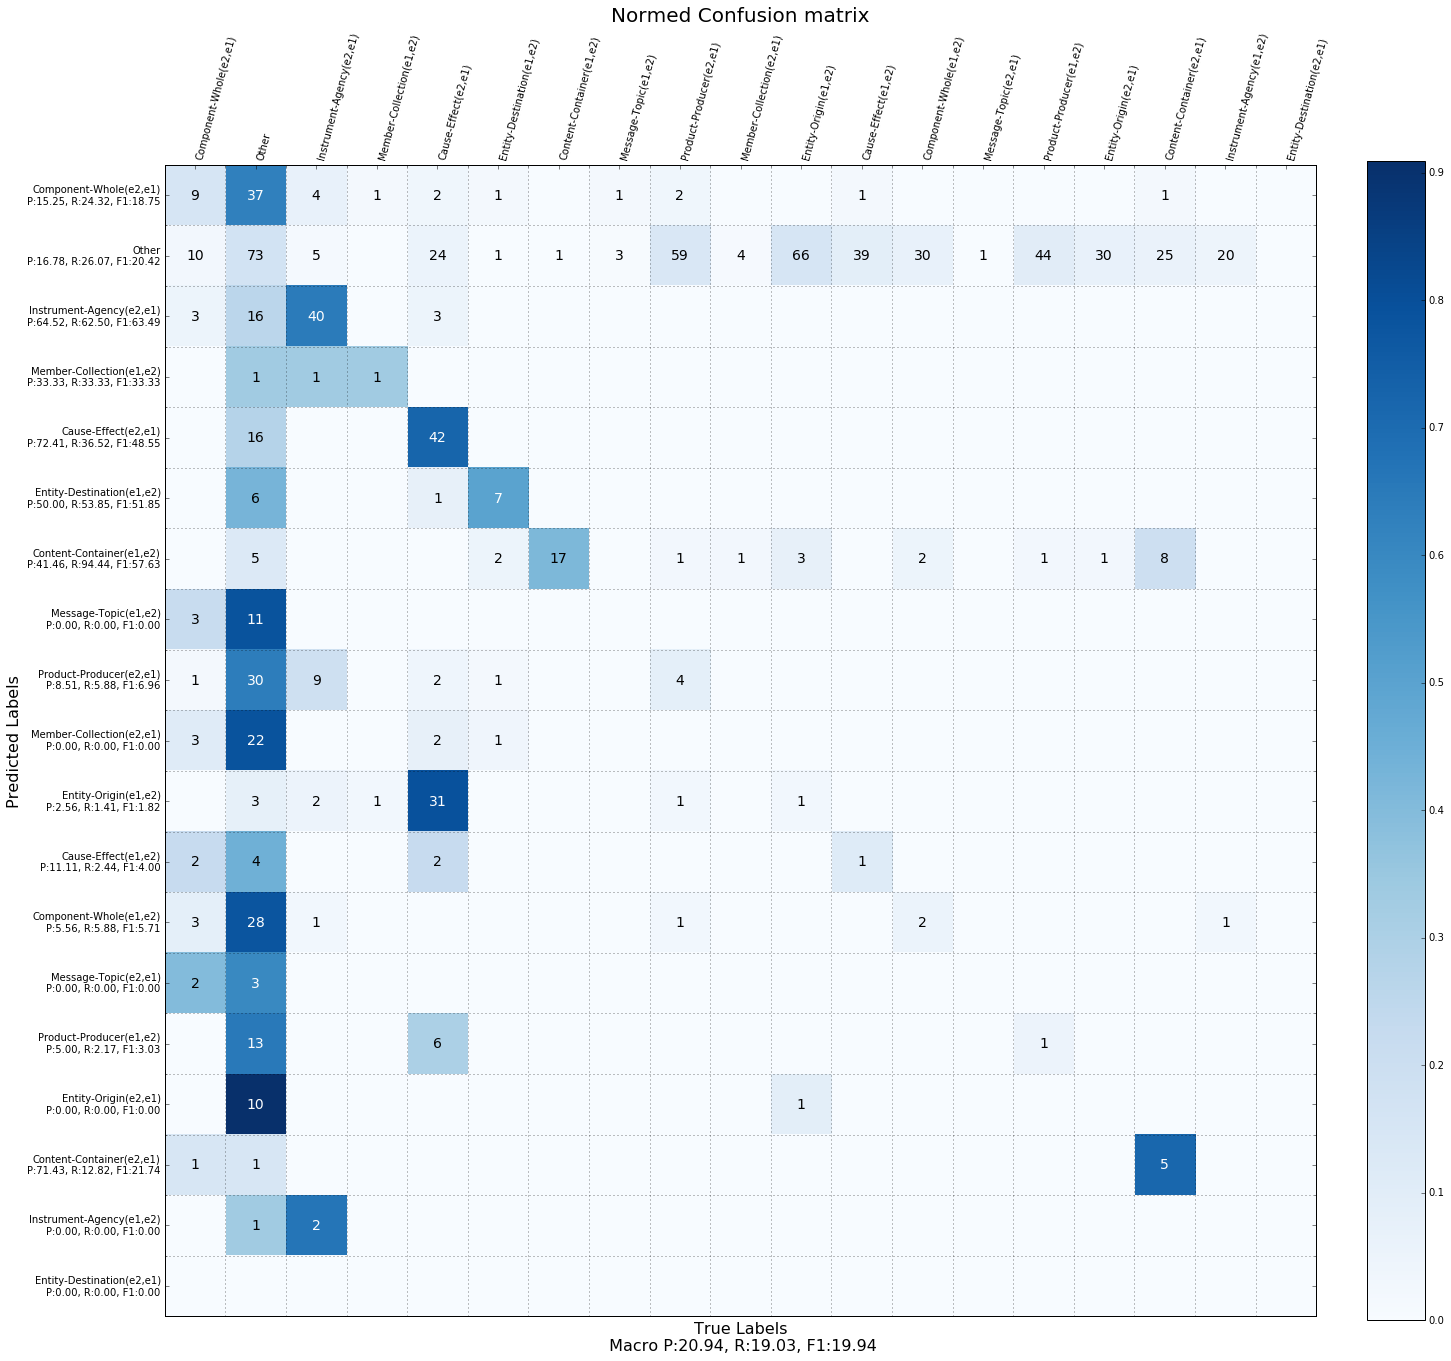

In [66]:
def plot_confusion_matrix(cm, label_names, save_name=None, title='Normed Confusion matrix', cmap=plt.cm.Blues, stats=None):
    fig, ax = plt.subplots(figsize=(20,20))
    
    # calc normalized cm
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    cm_max = np.max(cm_normalized)
    cm_min = np.min(cm_normalized)
    half_way = (cm_max - cm_min)/2.
    # print nonzero raw counts
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        norm = cm_normalized[x_val, y_val]
        c = "%i" % (cm.astype('int')[x_val, y_val])
        if norm > 0.0:
            color = 'white' if norm > half_way else 'black'
            ax.text(y_val, x_val, c, va='center', ha='center', color=color, fontsize=14)
    
    # actual plot
    im = ax.imshow(cm_normalized, interpolation='nearest', origin='upper', cmap=cmap)
#     divider = plt.make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # set ticks and offset grid
    tick_marks = np.arange(len(label_names))
    tick_marks_offset = np.arange(len(label_names)) - .5
    ax.set_xticks(tick_marks, minor=False)
    ax.set_yticks(tick_marks, minor=False)
    ax.set_xticks(tick_marks_offset, minor=True)
    ax.set_yticks(tick_marks_offset, minor=True)
    ax.grid(which='minor')
    if stats:
        # include micro precisio, recall, and f1
        aug_y_labels = []
        for i in range(len(label_names)):
            aug = ("%s\nP:%2.2f, R:%2.2f, F1:%2.2f" 
                   % (label_names[i],
                      stats['micro_precision'][i],
                      stats['micro_recall'][i],
                      stats['micro_f1'][i],))
            aug_y_labels.append(aug)
    else:
        aug_x_labels = label_names
    ax.set_xticklabels(label_names, rotation=75, horizontalalignment='left', x=1)
    ax.xaxis.tick_top()
    ax.set_yticklabels(aug_y_labels)
    
    # other stuff
    plt.tight_layout()
    plt.ylabel('Predicted Labels', fontsize=16)
    if stats:
        # include macro 
        aug_x_label = ("True Labels\n Macro P:%2.2f, R:%2.2f, F1:%2.2f" 
                       % (stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    else:
        aug_x_label = "True Label"
    plt.xlabel(aug_x_label, fontsize=16)
    plt.title(title, y=1.12, fontsize=20)
    if save_name:
        plt.savefig(save_name+'.pdf')
        

save_name = raw_input("Enter save name: (last was '%s') " % save_name)
plot_confusion_matrix(cm, int2label.values(), save_name=save_name, stats=stats)

In [67]:
# write out predictions for test set
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False)
preds, dists = drnn.predict(test_batch[0], test_batch[1], test_batch[2], return_probs=True)
print(len(test['targets']))

2717


In [68]:
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

In [69]:
# # reformat test keys because apparently that's broken...
# test_keys =  open("SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT", 'r').readlines()
# with open("SemEval2010_task8_all_data/test_keys.txt", 'w') as out:
#     for i in range(len(test_keys) //4):
#         num = test_keys[4*i].split()[0]
#         label = test_keys[4*i+1]
#         out.write("%s\t%s" % (num, label))

In [70]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_format_checker.pl \
SemEval2010_task8_all_data/test_pred.txt;
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_format_checker.pl \
SemEval2010_task8_all_data/test_keys.txt;
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt;


<<< The file format is OK.

<<< The file format is OK.
<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 |  55   23    1    8    0    0    2    0    0    1    0    0    0    2    5    2    1    3   31 |  134    0  134
 C-E2 |   8  102    4    8    0    0    0    0    0    1    0    0    0   11    1    1    3    5   50 |  194    0  194
 C-W1 |   1    1  104   16    3    0    1    0    0    1    0    5    3    6    2    0    0    4   15 |  162    0  162
 C-W2 |   0    1    7   92    2    0    3    0    0    0    0    4    0    3    4    1    2    9   22 |  150    0  150
 C-C1 |   0    0    4   18   69    4   21    0    0    2    0    3    1    3    4    0    1    8   15 |  153    0  153
 C-C2 |   0    0    1    7    1  

# Soft bootstrapping

In [ ]:
# hyperparameters
num_cycles = 3
num_epochs = 1
batch_size =50
num_steps = len(train['labels']) // batch_size

neg_per = 10
neg_level = 2
num_nearby = 30
nearby_mod = 200
sample_power = .75
DH.scale_vocab_dist(sample_power)

display_mod = 10
valid_mod = 50
best_valid = 100

# bookkeeping
num_steps = DH.num_steps(batch_size)
num_class_steps = len(train['labels']) // batch_size
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()
early_stop_model = None

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for cycle in range(num_cycles):
    # run the unsupervised
    for epoch in range(num_epochs):
        offset = 450 if cycle == 0 and epoch == 0 else 0
        DH.shuffle_data()
        for step , batch in enumerate(DH.batches(batch_size, offset=offset, neg_per=neg_per)):
            if not step: step = offset
            t0 = time()
            loss = drnn.partial_unsup_fit(*batch)
            fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
            if step % 10 == 0:
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
                ml,sl = divmod(left, 60)
                hl,ml = divmod(ml, 60)
                pps = batch_size*(neg_per + 1) / fit_time 
                print("%i (%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                      % (cycle, h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
            if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
                t0 = time()
                run_validation_test(num_nearby) # check out the nearby phrases in the validation set
                valid_loss = drnn.validation_loss(*DH.validation_batch())
                print("Validation loss: %0.4f" % valid_loss)
                nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

            if (time() - save_time) > save_interval:
                print("Saving model...")
                drnn.checkpoint()
                save_time = time()
            total_step +=1
            
    # final validation        
    run_validation_test(num_nearby) # check out the nearby phrases in the validation set
    valid_loss = drnn.validation_loss(*DH.validation_batch())
    print("Validation loss: %0.4f" % valid_loss)
    
    # run supervised
    for epoch in range(num_epochs):
        for step in range(num_class_steps): # num_steps
            class_batch = DH.classification_batch(batch_size, train['sdps'], train['targets'], train['labels'], 
                                                  offset=step, shuffle=True)
            xent = drnn.partial_class_fit(*class_batch)
            if step % display_mod == 0:   
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print("%i (%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f" 
                      % (cycle, h,m,s, step, num_class_steps, epoch, xent))
            if step % valid_mod == 0:
                valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], 
                                                      valid['targets'], valid['labels'])
                valid_xent = drnn.validation_class_loss(*valid_batch)
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print("="*80)
                print("% i(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" 
                      % (cycle, h,m,s, step, num_class_steps, epoch, valid_xent))
                print("="*80)
                if valid_xent < .95*best_valid:
                    print("New best validation")
                    best_valid = valid_xent
                    early_stop_model = drnn.checkpoint()

    # do a final validation
    valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'])
    valid_xent = drnn.validation_class_loss(*valid_batch)
    m,s = divmod(time()-start, 60)
    h,m = divmod(m, 60)
    print("="*80)
    print("%i (%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f" 
          % (cycle, h,m,s, step, num_class_steps, epoch, valid_xent))
    print("="*80)
    model_file = drnn.checkpoint()
    if valid_xent < .95*best_valid:
        best_valid = valid_xent
        early_stop_model = model_file
    drnn.checkpoint()
    
    preds, dists = drnn.predict(valid_batch[0], valid_batch[1], valid_batch[2], return_probs=True)
    label_set = set(train['labels'])
    cm, stats = confusion_matrix(preds, valid['labels'], label_set)
    print("Macro F1: %2.4f" % stats['macro_f1'])
    
# now take the best of all
print("best model was %s" % early_stop_model)
drnn.checkpoint()

0 (0:0:1) step 450/3224, epoch 0 Training Loss = 0.59912 :: 920.579 phrases/sec :: (0:32:4) hours left
Top 30 closest phrases to <development> '<X> continues be <Y>' <threat>
0: 1.000 : <development> '<X> continues be <Y>' <threat>
1: 0.995 : <differences> '<X> presumed be <Y>' <result>
2: 0.976 : <he> '<X> said become <Y>' <fellow>
3: 0.973 : <satellite> '<X> destroy breached <Y>' <core>
4: 0.963 : <it> '<X> believed think <Y>' <scholars>
5: 0.960 : <<OOV>> '<X> laid deemed <Y>' <number>
6: 0.960 : <he> '<X> became treasurer <Y>' <secretary>
7: 0.959 : <agencies> '<X> operate leased <Y>' <remainder>
8: 0.955 : <<OOV>> '<X> be revealed find <Y>' <<OOV>>
9: 0.955 : <church> '<X> became converted <Y>' <buildings>
10: 0.952 : <highway> '<X> climbs becoming <Y>' <course>
11: 0.951 : <village> '<X> handed changed <Y>' <grandson>
12: 0.950 : <judges> '<X> maintain broadcast <Y>' <<OOV>>
13: 0.948 : <<OOV>> '<X> appointed sacked <Y>' <club>
14: 0.947 : <he> '<X> became be <Y>' <part>
15: 0.94